In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
from pandas import concat
import keras
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,LSTM

# Detecting outliers for T2B5

In [2]:
record = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', 'RecordList')
T2B5 = record[record.Standard == 'T2B5'].RecordID.values
T2B5 = [str(i).zfill(9) for i in T2B5]

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Training model for NOx_ppm

In [4]:
lag = 2
ppm_model = Sequential()
ppm_model.add(LSTM(50, input_shape=(lag, 5)))
ppm_model.add(Dense(1))
ppm_model.compile(loss='mae', optimizer='adam')
performance = []

for record in T2B5:
    df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
    df = df.dropna()
    df = df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm']]
    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(df.values)
    # Reshape data
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values
    train_X = values[:, :-1]
    train_y = values[:,-1]
    train_X = train_X.reshape((train_X.shape[0], lag, -1))
    ppm_model.fit(train_X, train_y, epochs=50, batch_size=72, shuffle=False, verbose=0)

### Plot outliers for each record

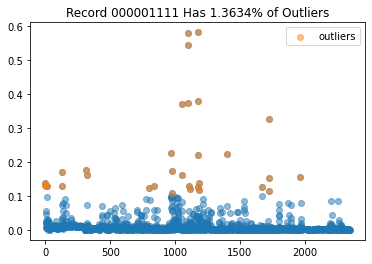

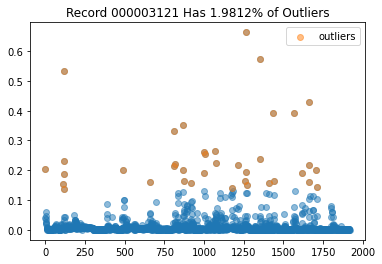

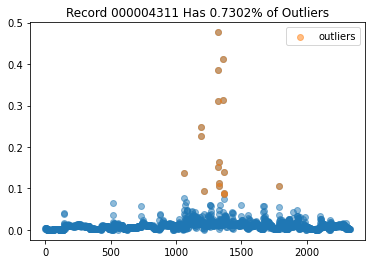

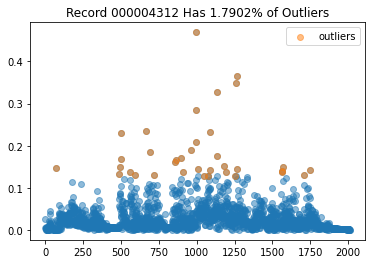

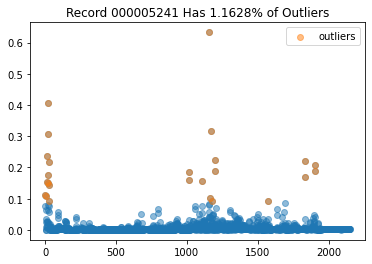

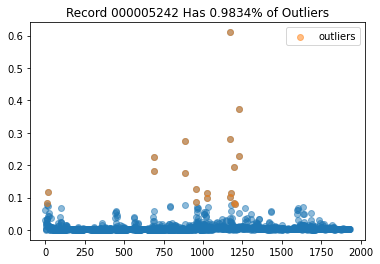

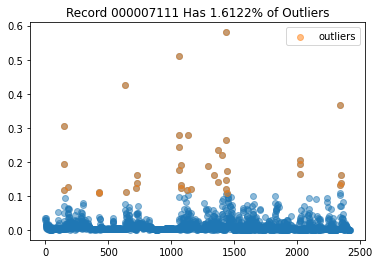

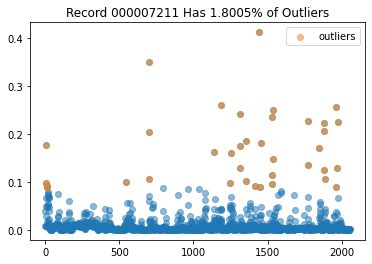

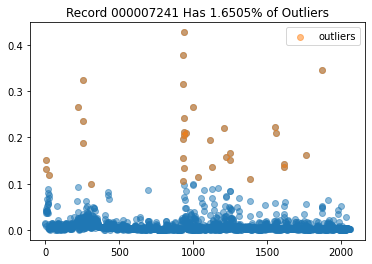

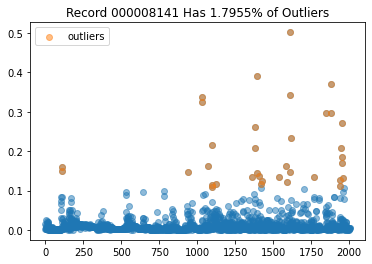

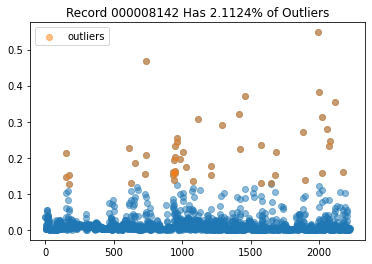

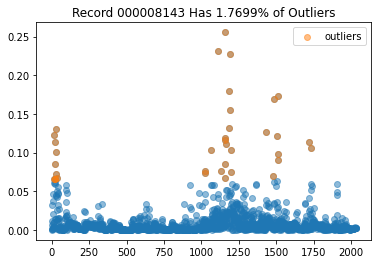

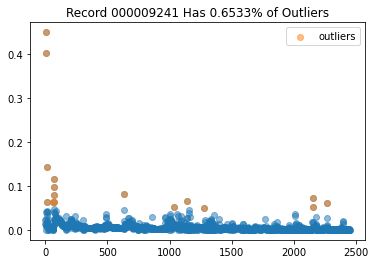

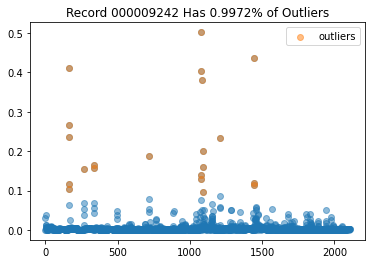

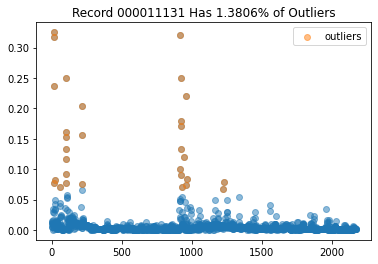

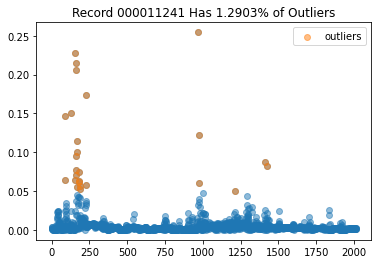

In [5]:
rec_length = {}
# Save percentage of outliers for each record
diff_percent = {}
# Save positions of outliers for each record
out_pos = {}
for record in T2B5:
    df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
    df = df.dropna()
    df = df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm']]
    rec_length[record]=len(df)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(df.values)
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values   
    X = values[:, :-1]
    y = values[:,-1]
    X = X.reshape((X.shape[0], lag, -1))
    # Get yhat at every time stemp
    predicted = ppm_model.predict(X).reshape(-1)
    # Compute distance between y and yhat
    diff = abs(predicted-y)
    # Compute outlier threshold
    bar = np.mean(diff)+3*np.std(diff)
    # Get outliers positions based on the threshold
    outliers_pos = np.where(diff > bar)[0]
    # record positions to the list
    out_pos[record]=outliers_pos
    # Get percentage of outliers
    per = len(outliers_pos) / X.shape[0]
    # Append it to the list
    diff_percent[record]=per
    # Making plot
    plt.scatter(range(len(diff)), diff, alpha=0.5) # Plot residuals 
    plt.scatter(outliers_pos, diff[outliers_pos],label='outliers', alpha=0.5) # Ploting outliers
    plt.title(f'Record {record} Has {per*100:.4f}% of Outliers')
    plt.legend()
    plt.show()

# Plotting distribution of relative outlier positions

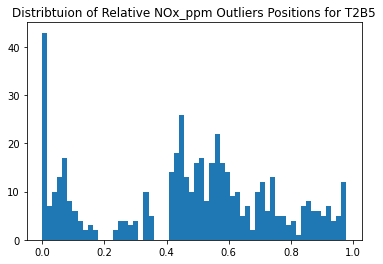

In [6]:
# Record relative positions
rel_pos = []
# Loop the out_pos list
for record in T2B5:
    length = rec_length[record]
    # Get relative positions for each outlier
    temp = [t/length for t in out_pos[record]]
    rel_pos.append(temp)
# since rel_pos is a nested list, I flatten it
plt.hist([item for sublist in rel_pos for item in sublist], bins=60)
plt.title('Distribtuion of Relative NOx_ppm Outliers Positions for T2B5')
plt.show()

## Plotting Outlier Percentage for each record and sorted by ascending order

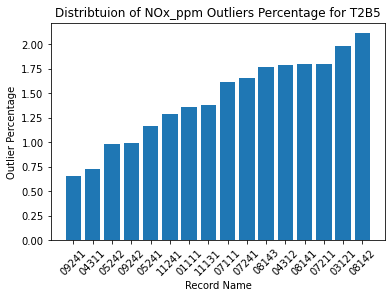

In [7]:
sorted_perc = {k: v for k, v in sorted(diff_percent.items(), key=lambda item: item[1])}
plt.bar([i[4:] for i in sorted_perc], [i*100 for i in sorted_perc.values()])
plt.xticks(rotation=45)
plt.xlabel('Record Name')
plt.ylabel('Outlier Percentage')
plt.title('Distribtuion of NOx_ppm Outliers Percentage for T2B5')
plt.show()

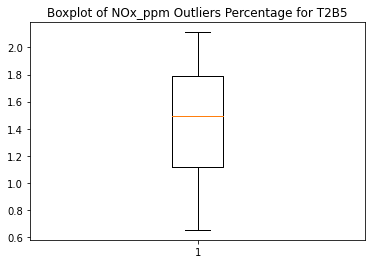

In [8]:
plt.boxplot([i*100 for i in sorted_perc.values()])
plt.title('Boxplot of NOx_ppm Outliers Percentage for T2B5')
plt.show()

## Plotting outlier positions back to origianl dataset for the record with most percentage of outliers

In [9]:
sorted_perc

{'000009241': 0.006533278889342589,
 '000004311': 0.007302405498281787,
 '000005242': 0.009834368530020704,
 '000009242': 0.009971509971509971,
 '000005241': 0.011627906976744186,
 '000011241': 0.012903225806451613,
 '000001111': 0.013634426927993182,
 '000011131': 0.013805798435342844,
 '000007111': 0.016122364613476645,
 '000007241': 0.01650485436893204,
 '000008143': 0.017699115044247787,
 '000004312': 0.01790154152163103,
 '000008141': 0.017955112219451373,
 '000007211': 0.01800486618004866,
 '000003121': 0.01981230448383733,
 '000008142': 0.021123595505617977}

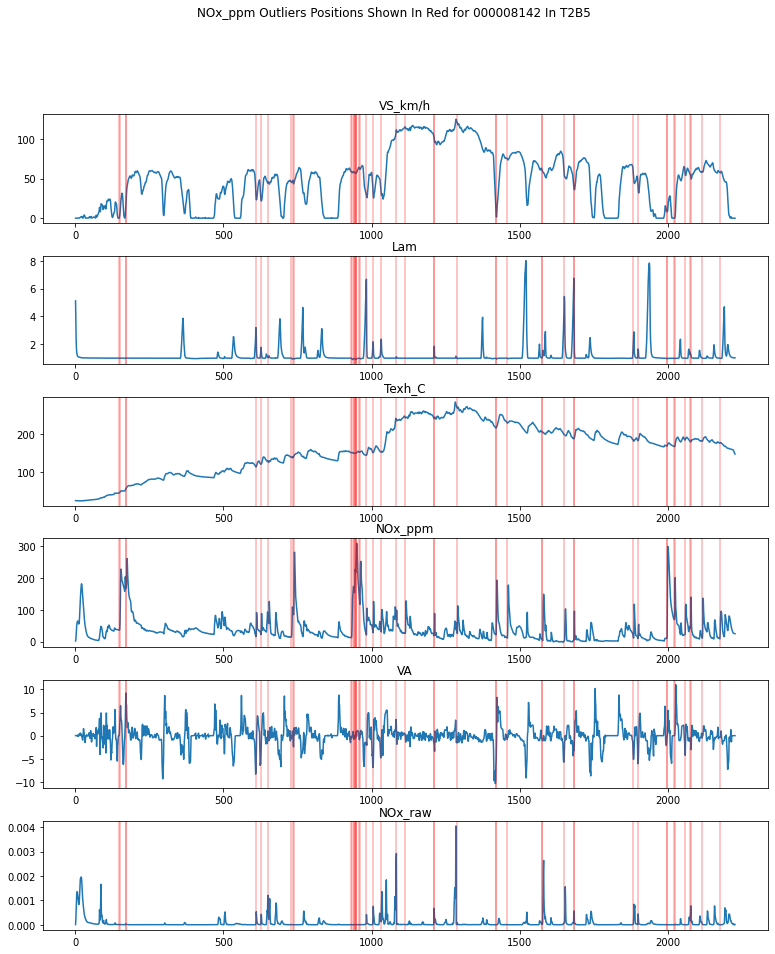

In [10]:
record = '000008142'
df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
df = df.dropna()
fig, axes = plt.subplots(6,1,figsize=(13,15))
for i in range(6):
    axes[i].plot(df.iloc[:, 0], df.iloc[:, i+1])
    axes[i].set_title(df.columns[i+1])
    for pos in out_pos[record]:
        axes[i].axvline(pos,color='r',alpha=0.3)

plt.subplots_adjust(hspace=0.3)
fig.suptitle("NOx_ppm Outliers Positions Shown In Red for "+record+" In T2B5")
plt.show()

# NOx_row

In [11]:
lag = 2
raw_model = Sequential()
raw_model.add(LSTM(50, input_shape=(lag, 5)))
raw_model.add(Dense(1))
raw_model.compile(loss='mae', optimizer='adam')
performance = []

for record in T2B5:
    df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
    df = df.dropna()
    df = df[['VS_km/h','Lam','Texh_C','VA','NOx_raw']]
    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(df.values)
    # Reshape data
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values
    train_X = values[:, :-1]
    train_y = values[:,-1]
    train_X = train_X.reshape((train_X.shape[0], lag, -1))
    ppm_model.fit(train_X, train_y, epochs=50, batch_size=72, shuffle=False, verbose=0)

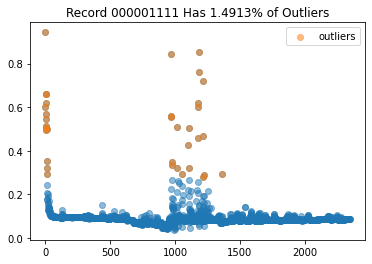

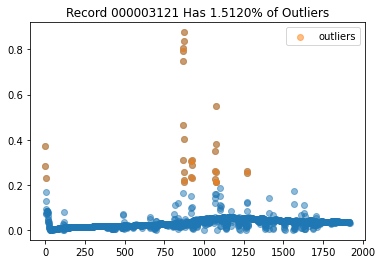

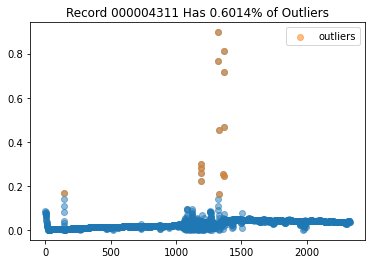

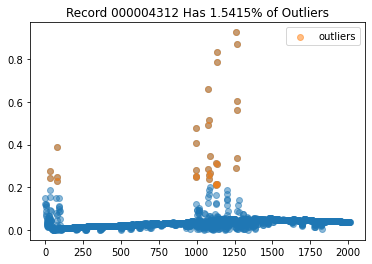

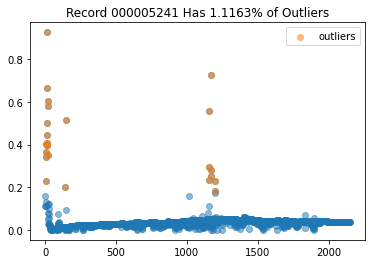

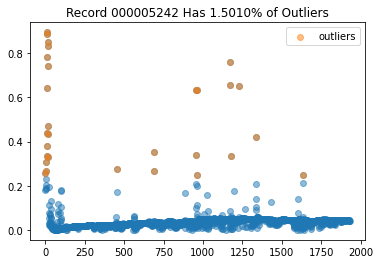

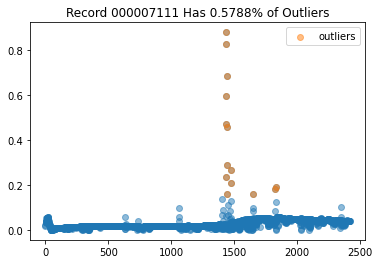

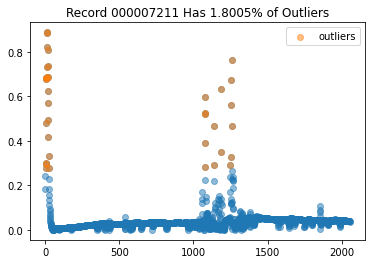

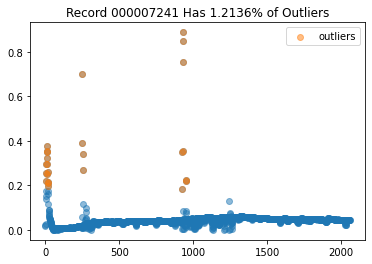

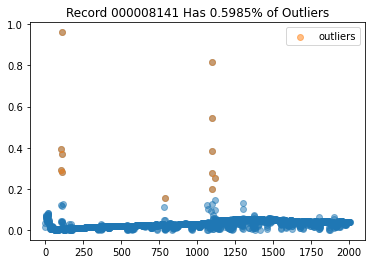

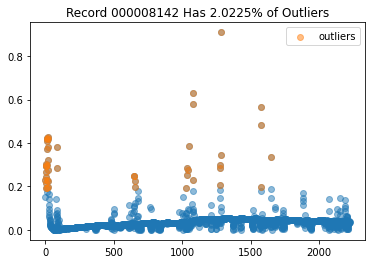

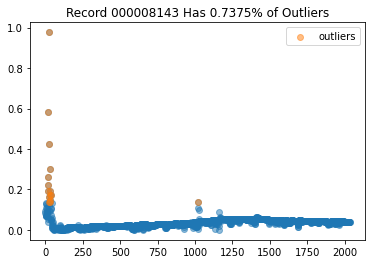

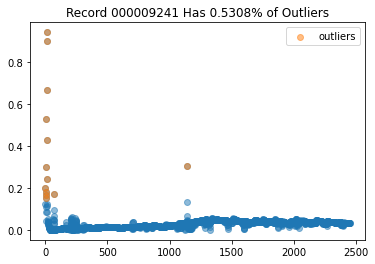

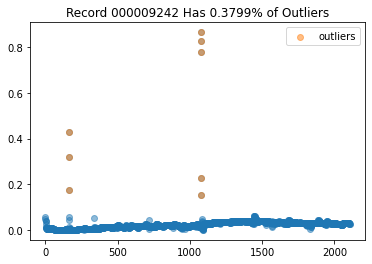

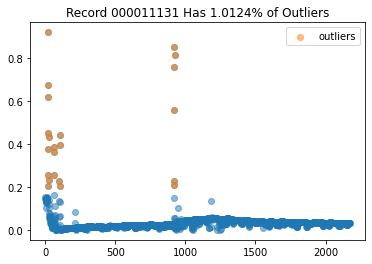

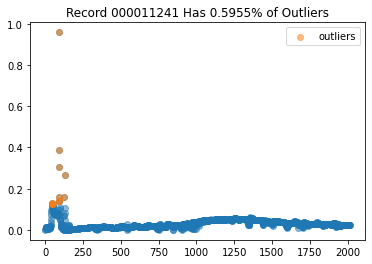

In [12]:
rec_length = {}
# Save percentage of outliers for each record
diff_percent = {}
# Save positions of outliers for each record
out_pos = {}
for record in T2B5:
    df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
    df = df.dropna()
    df = df[['VS_km/h','Lam','Texh_C','VA','NOx_raw']]
    rec_length[record]=len(df)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(df.values)
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values   
    X = values[:, :-1]
    y = values[:,-1]
    X = X.reshape((X.shape[0], lag, -1))
    # Get yhat at every time stemp
    predicted = raw_model.predict(X).reshape(-1)
    # Compute distance between y and yhat
    diff = abs(predicted-y)
    # Compute outlier threshold
    bar = np.mean(diff)+3*np.std(diff)
    # Get outliers positions based on the threshold
    outliers_pos = np.where(diff > bar)[0]
    # record positions to the list
    out_pos[record]=outliers_pos
    # Get percentage of outliers
    per = len(outliers_pos) / X.shape[0]
    # Append it to the list
    diff_percent[record]=per
    # Making plot
    plt.scatter(range(len(diff)), diff, alpha=0.5) # Plot residuals 
    plt.scatter(outliers_pos, diff[outliers_pos],label='outliers', alpha=0.5) # Ploting outliers
    plt.title(f'Record {record} Has {per*100:.4f}% of Outliers')
    plt.legend()
    plt.show()

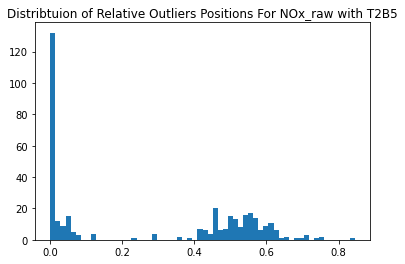

In [13]:
# Record relative positions
rel_pos = []
# Loop the out_pos list
for record in T2B5:
    length = rec_length[record]
    # Get relative positions for each outlier
    temp = [t/length for t in out_pos[record]]
    rel_pos.append(temp)
# since rel_pos is a nested list, I flatten it
plt.hist([item for sublist in rel_pos for item in sublist], bins=60)
plt.title('Distribtuion of Relative Outliers Positions For NOx_raw with T2B5')
plt.show()

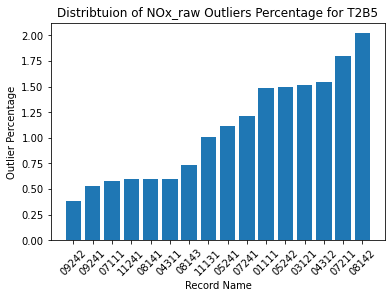

In [14]:
sorted_perc = {k: v for k, v in sorted(diff_percent.items(), key=lambda item: item[1])}
plt.bar([i[4:] for i in sorted_perc], [i*100 for i in sorted_perc.values()])
plt.xticks(rotation=45)
plt.xlabel('Record Name')
plt.ylabel('Outlier Percentage')
plt.title('Distribtuion of NOx_raw Outliers Percentage for T2B5')
plt.show()

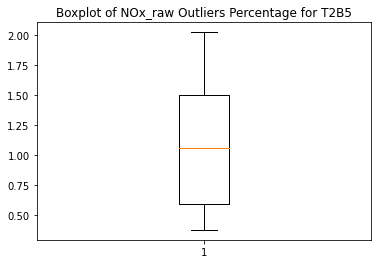

In [15]:
plt.boxplot([i*100 for i in sorted_perc.values()])
plt.title('Boxplot of NOx_raw Outliers Percentage for T2B5')
plt.show()

In [16]:
sorted_perc

{'000009242': 0.003798670465337132,
 '000009241': 0.005308289097590854,
 '000007111': 0.005787515502273667,
 '000011241': 0.005955334987593052,
 '000008141': 0.0059850374064837905,
 '000004311': 0.006013745704467354,
 '000008143': 0.007374631268436578,
 '000011131': 0.010124252185918085,
 '000005241': 0.011162790697674419,
 '000007241': 0.012135922330097087,
 '000001111': 0.014912654452492544,
 '000005242': 0.015010351966873706,
 '000003121': 0.015119916579770595,
 '000004312': 0.015415216310293387,
 '000007211': 0.01800486618004866,
 '000008142': 0.020224719101123594}

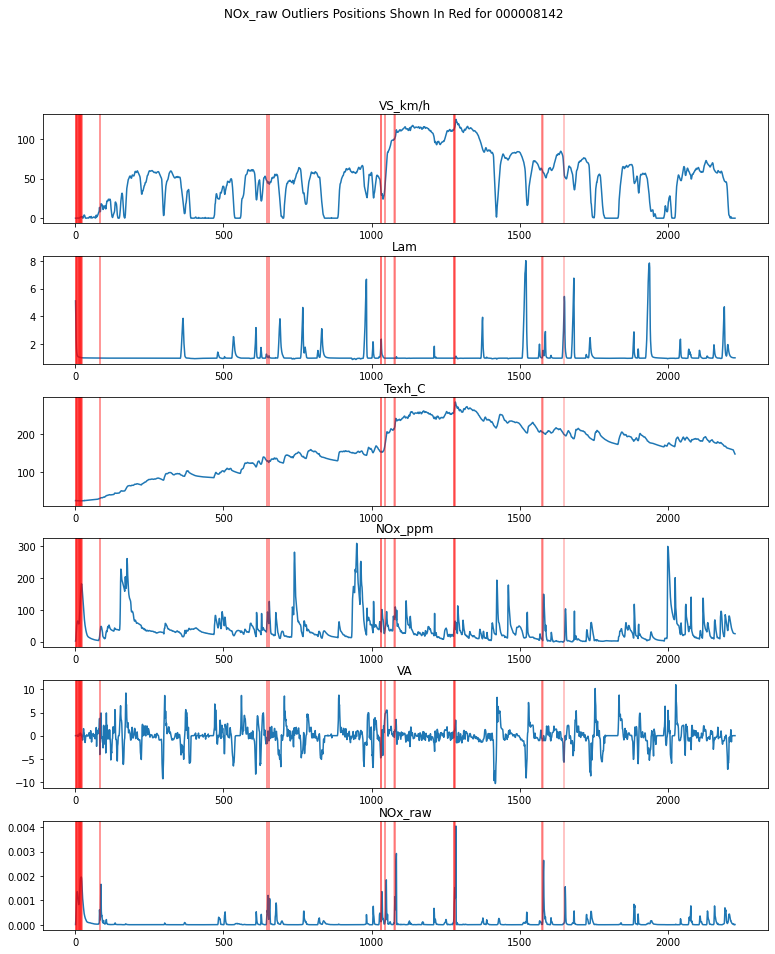

In [17]:
record = '000008142'
df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
df = df.dropna()
fig, axes = plt.subplots(6,1,figsize=(13,15))
for i in range(6):
    axes[i].plot(df.iloc[:, 0], df.iloc[:, i+1])
    axes[i].set_title(df.columns[i+1])
    for pos in out_pos[record]:
        axes[i].axvline(pos,color='r',alpha=0.3)

plt.subplots_adjust(hspace=0.3)
fig.suptitle("NOx_raw Outliers Positions Shown In Red for "+record)
plt.show()

# Second most standard

In [27]:
record = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', 'RecordList')
T2B4 = record[record.Standard == 'T2B4'].RecordID.values
T2B4 = [str(i).zfill(9) for i in T2B4]

In [28]:
lag = 2
ppm_model = Sequential()
ppm_model.add(LSTM(50, input_shape=(lag, 5)))
ppm_model.add(Dense(1))
ppm_model.compile(loss='mae', optimizer='adam')
performance = []

for record in T2B4:
    df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
    df = df.dropna()
    df = df[['VS_km/h','Lam','Texh_C','VA','NOx_raw']]
    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(df.values)
    # Reshape data
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values
    train_X = values[:, :-1]
    train_y = values[:,-1]
    train_X = train_X.reshape((train_X.shape[0], lag, -1))
    ppm_model.fit(train_X, train_y, epochs=50, batch_size=72, shuffle=False, verbose=0)

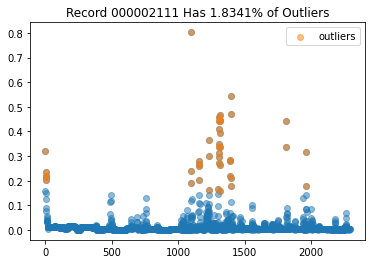

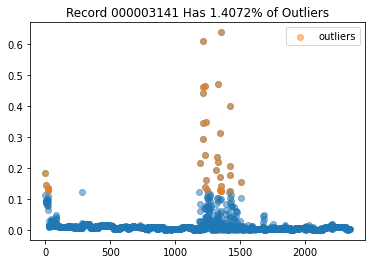

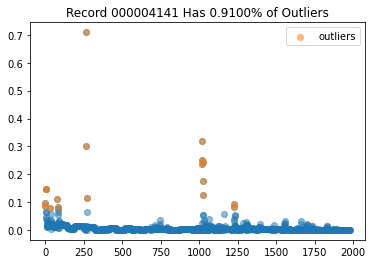

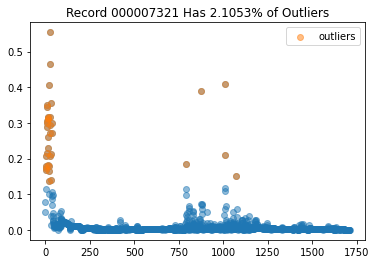

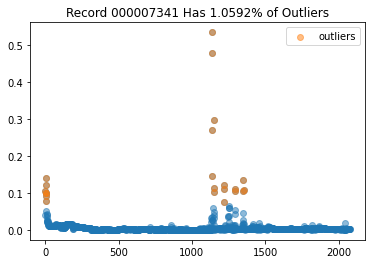

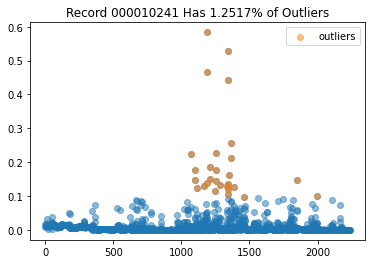

In [29]:
rec_length = {}
# Save percentage of outliers for each record
diff_percent = {}
# Save positions of outliers for each record
out_pos = {}
for record in T2B4:
    df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
    df = df.dropna()
    df = df[['VS_km/h','Lam','Texh_C','VA','NOx_raw']]
    rec_length[record]=len(df)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(df.values)
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values   
    X = values[:, :-1]
    y = values[:,-1]
    X = X.reshape((X.shape[0], lag, -1))
    # Get yhat at every time stemp
    predicted = ppm_model.predict(X).reshape(-1)
    # Compute distance between y and yhat
    diff = abs(predicted-y)
    # Compute outlier threshold
    bar = np.mean(diff)+3*np.std(diff)
    # Get outliers positions based on the threshold
    outliers_pos = np.where(diff > bar)[0]
    # record positions to the list
    out_pos[record]=outliers_pos
    # Get percentage of outliers
    per = len(outliers_pos) / X.shape[0]
    # Append it to the list
    diff_percent[record]=per
    # Making plot
    plt.scatter(range(len(diff)), diff, alpha=0.5) # Plot residuals 
    plt.scatter(outliers_pos, diff[outliers_pos],label='outliers', alpha=0.5) # Ploting outliers
    plt.title(f'Record {record} Has {per*100:.4f}% of Outliers')
    plt.legend()
    plt.show()

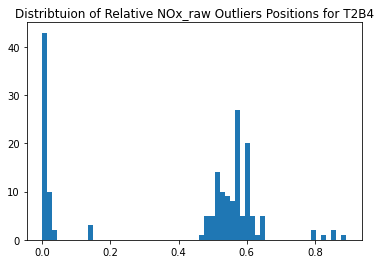

In [35]:
# Record relative positions
rel_pos = []
# Loop the out_pos list
for record in T2B4:
    length = rec_length[record]
    # Get relative positions for each outlier
    temp = [t/length for t in out_pos[record]]
    rel_pos.append(temp)
# since rel_pos is a nested list, I flatten it
plt.hist([item for sublist in rel_pos for item in sublist], bins=60)
plt.title('Distribtuion of Relative NOx_raw Outliers Positions for T2B4')
plt.show()

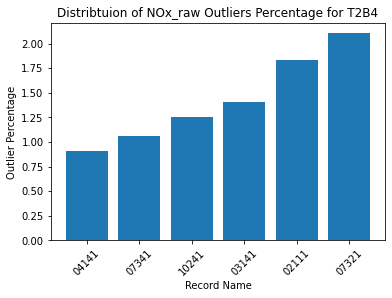

In [36]:
sorted_perc = {k: v for k, v in sorted(diff_percent.items(), key=lambda item: item[1])}
plt.bar([i[4:] for i in sorted_perc], [i*100 for i in sorted_perc.values()])
plt.xticks(rotation=45)
plt.xlabel('Record Name')
plt.ylabel('Outlier Percentage')
plt.title('Distribtuion of NOx_raw Outliers Percentage for T2B4')
plt.show()

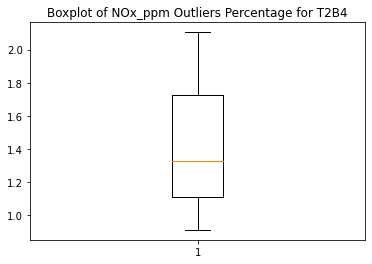

In [37]:
plt.boxplot([i*100 for i in sorted_perc.values()])
plt.title('Boxplot of NOx_ppm Outliers Percentage for T2B4')
plt.show()

In [38]:
sorted_perc

{'000004141': 0.00910010111223458,
 '000007341': 0.01059220028887819,
 '000010241': 0.012516763522574878,
 '000003141': 0.014072494669509595,
 '000002111': 0.01834061135371179,
 '000007321': 0.021052631578947368}

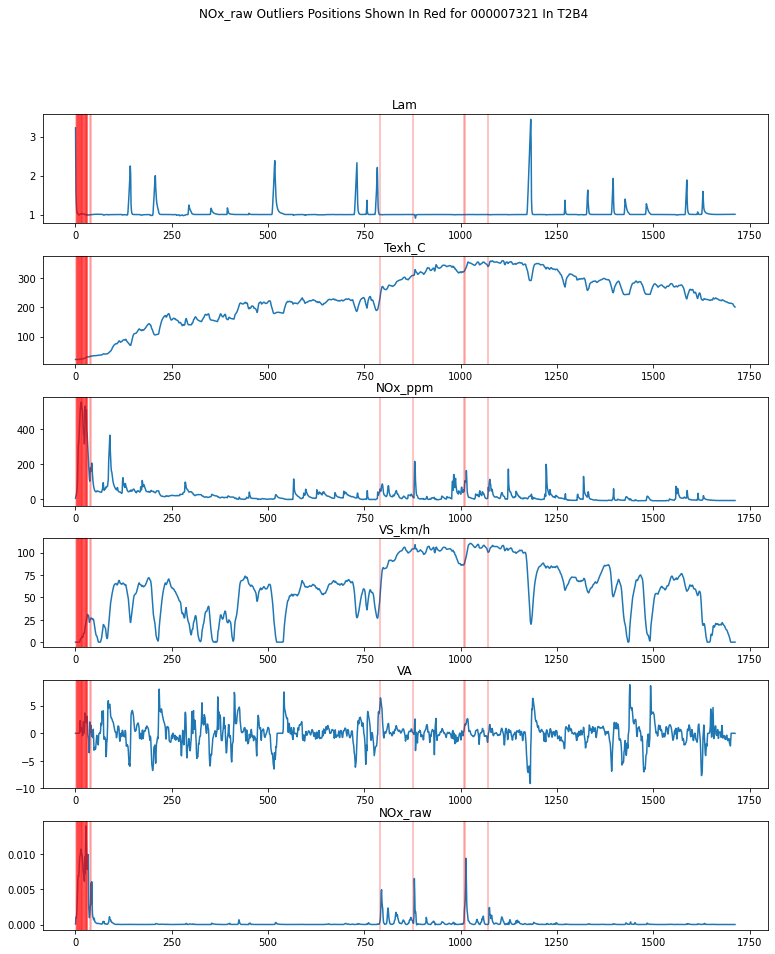

In [40]:
record = '000007321'
df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
df = df.dropna()
fig, axes = plt.subplots(6,1,figsize=(13,15))
for i in range(6):
    axes[i].plot(df.iloc[:, 0], df.iloc[:, i+1])
    axes[i].set_title(df.columns[i+1])
    for pos in out_pos[record]:
        axes[i].axvline(pos,color='r',alpha=0.3)

plt.subplots_adjust(hspace=0.3)
fig.suptitle("NOx_raw Outliers Positions Shown In Red for "+record+" In T2B4")
plt.show()